In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit.circuit import QuantumCircuit, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate, XGate

from qiskit_algorithms import optimizers
from qiskit.primitives import Estimator

from scipy.optimize import minimize

# import matplotlib.pyplot as plt

from qiskit import *
from qiskit.visualization import *
# from qiskit_aer import Aer

from qiskit_nature.second_q.hamiltonians import ElectronicEnergy
from qiskit_nature.second_q.problems import ElectronicStructureProblem
from qiskit_nature.second_q.properties import ParticleNumber
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper

# Para cargar lo necesario
import pickle

### Función para expandir el observable

In [2]:
def expand_hamiltonian(op, total_qubits):
    expanded_paulis = []
    for pauli, coeff in zip(op.paulis, op.coeffs):
        pauli_str = pauli.to_label()
        # Añadir identidades antes y después según la posición deseada
        new_pauli = (
            pauli_str + "I" * (total_qubits - len(pauli_str))
        )
        expanded_paulis.append((new_pauli, coeff))
    return SparsePauliOp.from_list(expanded_paulis)

### Función para crear el ansatz

In [8]:
def build_deep_ansatz(num_qubits):
    """Crea un circuito con L = 10n capas de ansatz para n qubits."""
    L = 10 * num_qubits  # número de capas
    qc = QuantumCircuit(num_qubits)
    thetas = []

    def layer(qc, theta_list):
        # RX en cada qubit
        for i in range(num_qubits):
            qc.rx(theta_list[i], i)
        # CZ entre qubits adyacentes
        for i in range(num_qubits - 1):
            qc.cz(i, i + 1)

    for layer_index in range(L):
        theta_layer = [Parameter(f'θ_{layer_index}_{i}') for i in range(num_qubits)]
        thetas.append(theta_layer)
        layer(qc, theta_layer)
        qc.barrier()

    return qc, thetas

### Función para calcular la energía

In [ ]:
def evaluate_energy(params, circuit, hamiltonian, estimator):
    bound_circuit = circuit.bind_parameters(params)
    job = estimator.run([bound_circuit], [hamiltonian])
    result = job.result()
    return result.values[0]

### Función para calcular el gradiente

In [ ]:
def parameter_shift_gradient(ansatz, theta_lists, hamiltonian, estimator, index, num_shots=100):
    gradient = []
    flat_params = [param for layer in theta_lists for param in layer]

    # Cálculo de gradientes
    for _ in range(num_shots):
        param_vector = np.random.uniform(0, 2 * np.pi, len(flat_params))  

        # Desplazamientos para parameter-shift
        shifted_plus = param_vector.copy()
        shifted_plus[index] += np.pi / 2
        shifted_minus = param_vector.copy()
        shifted_minus[index] -= np.pi / 2

        # Energías
        energy_plus = evaluate_energy(shifted_plus, ansatz, hamiltonian, estimator)
        energy_minus = evaluate_energy(shifted_minus, ansatz, hamiltonian, estimator)

        grad_i = 0.5 * (energy_plus - energy_minus)
        gradient.append(grad_i)

    return np.array(gradient)

    return np.array(gradient)

### Función para calcular la varianza

In [34]:
def gradient_variance(gradient_vector):
    return np.var(gradient_vector)

In [47]:
# Cargar el Hamiltoniano desde el archivo
with open("hamiltonian_hidrogen_reduced.pkl", "rb") as f:
    base_hamiltonian= pickle.load(f)
print(base_hamiltonian)

SparsePauliOp(['II', 'ZI', 'IZ', 'ZZ', 'YY', 'XX'],
              coeffs=[-0.4804+0.j,  0.3435+0.j, -0.4347+0.j,  0.5716+0.j,  0.091 +0.j,
  0.091 +0.j])


In [ ]:
for i in range (2,7):
    estimator = Estimator()

    # Expandimos el Hamiltoniano
    current_hamiltonian = expand_hamiltonian(base_hamiltonian, i)

    # Generamos el ansatz y parámetros
    ansatz, thetas = build_deep_ansatz(i)

    # Calculamos gradiente y varianza
    grad = parameter_shift_gradient(ansatz, thetas, current_hamiltonian, estimator)
    var = gradient_variance(grad)

    # print("Gradiente:", grad)
    print("Varianza del gradiente:", var, "para", i,"qubits")

C:\Users\Martín\AppData\Local\Temp\ipykernel_3808\2866020499.py:2: DeprecationWarning: The method ``qiskit.circuit.quantumcircuit.QuantumCircuit.bind_parameters()`` is deprecated as of qiskit 0.45.0. It will be removed no earlier than 3 months after the release date. Use assign_parameters() instead
  bound_circuit = circuit.bind_parameters(params)


Varianza del gradiente: 0.15988494854497354 para 2 qubits
Varianza del gradiente: 0.14516713254669228 para 3 qubits
Varianza del gradiente: 0.03694047593671992 para 4 qubits
Varianza del gradiente: 0.00867351746266787 para 5 qubits
Varianza del gradiente: 0.021685491338812306 para 6 qubits



Preparando ejecución para 2 qubits.
Se usarán 40 parámetros


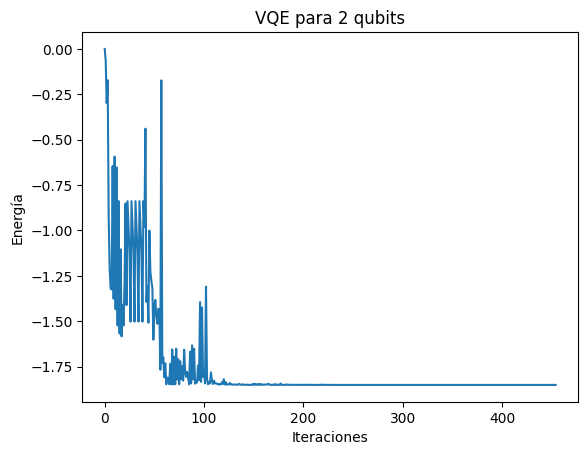

None

Fin ejecución con 2 qubits. Energía: -1.8511991202843687

Preparando ejecución para 3 qubits.
Se usarán 90 parámetros


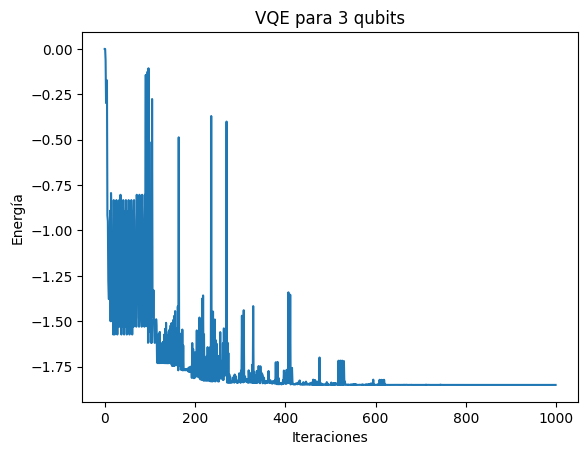

None

Fin ejecución con 3 qubits. Energía: -1.8511991185263916

Preparando ejecución para 4 qubits.
Se usarán 160 parámetros


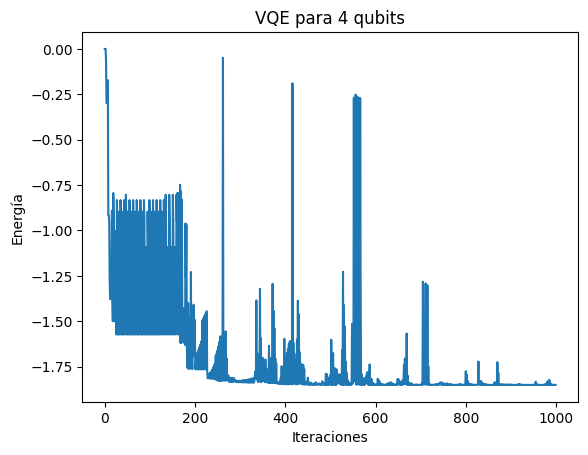

None

Fin ejecución con 4 qubits. Energía: -1.8511967759561976

Preparando ejecución para 5 qubits.
Se usarán 250 parámetros


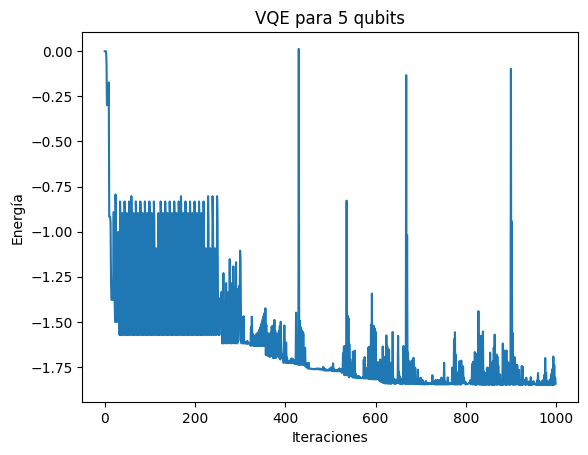

None

Fin ejecución con 5 qubits. Energía: -1.850011129694784

Preparando ejecución para 6 qubits.
Se usarán 360 parámetros


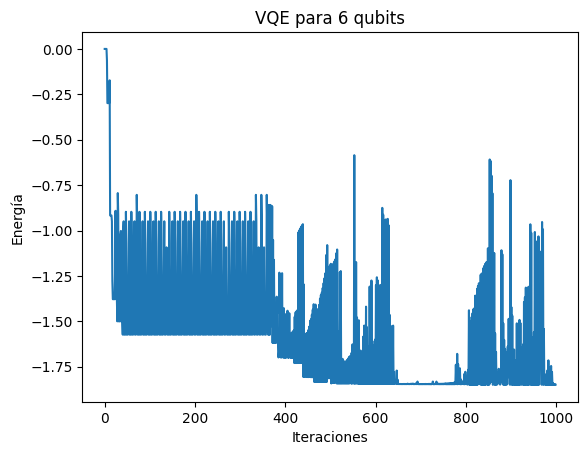

None

Fin ejecución con 6 qubits. Energía: -1.850362435946063

Preparando ejecución para 7 qubits.
Se usarán 490 parámetros


KeyboardInterrupt: 

In [49]:
max_qubits = 10

# Creamos el estimador para el simulador
estimator = Estimator()

for i in range(2, max_qubits+1):
    
    current_hamiltonian=expand_hamiltonian(base_hamiltonian, i)
    ansatz_circuit, thetas = build_deep_ansatz(i)

    # Parámetros iniciales
    x0 = np.zeros(len(thetas)*i)

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Preparando ejecución para {i} qubits.")
    print(f"Se usarán {len(thetas)*i} parámetros")

    # Diccionario para almacenar la evolución del costo
    cost_history_dict = {
        "iters": 0,
        "cost_history": [],
    }

    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]

        cost_history_dict["iters"] += 1
        cost_history_dict["cost_history"].append(energy)

        return energy

    # Ejecutamos la optimización
    res = minimize(
        cost_func,
        x0,
        args=(ansatz_circuit, current_hamiltonian, estimator),
        method="COBYLA",
    )

    # Graficar evolución del costo
    fig, ax = plt.subplots()
    ax.plot(range(cost_history_dict["iters"]), cost_history_dict["cost_history"])
    ax.set_xlabel("Iteraciones")
    ax.set_ylabel("Energía")
    ax.set_title(f"VQE para {i} qubits")
    display(plt.show())

    print(f"Fin ejecución con {i} qubits. Energía: {res.fun}")
    print("=====================================================")


### Gráfica Var(E) vs nQubits

In [31]:
# Cuantos qubits usar
max_qubits = 25

# Cuantos valores de la funcion de costo probar para calcular la varianza
N = 250

# Datos que pintamos al final
data = []

# Creamos el estimador para el simulador
estimator = Estimator()

# Bucle número de qubits
for i in range(2, max_qubits+1):

    # Información sobre la iteración actual
    print("\n=====================================================")
    print(f"Calculando varianza de la energía con {i} qubits.")
    
    current_hamiltonian=expand_hamiltonian(base_hamiltonian, i)
    ansatz_circuit, thetas = build_deep_ansatz(i)

    def cost_func(params, ansatz, hamiltonian, estimator):
        job = estimator.run([ansatz], [hamiltonian], [params])
        result = job.result()
        energy = result.values[0]
        return energy

    # Lista para guardar los valores aleatorios
    random_energy = []

    for j in range(N+1):
        x0 = np.random.random(len(thetas)*i)
        random_energy.append(cost_func(x0, ansatz_circuit, current_hamiltonian, estimator))
    
    data.append([np.var(random_energy), i])
        
data = np.array(data)

# Graficar evolución del costo
fig, ax = plt.subplots()
ax.scatter(data[:,1], data[:,0])
ax.set_xlabel("N qubits")
ax.set_ylabel("var(E)")
ax.set_title(f"BP en VQE")
ax.set_yscale("log")
display(plt.show())


Calculando varianza de la energía con 2 qubits.

Calculando varianza de la energía con 3 qubits.

Calculando varianza de la energía con 4 qubits.

Calculando varianza de la energía con 5 qubits.

Calculando varianza de la energía con 6 qubits.

Calculando varianza de la energía con 7 qubits.

Calculando varianza de la energía con 8 qubits.

Calculando varianza de la energía con 9 qubits.

Calculando varianza de la energía con 10 qubits.

Calculando varianza de la energía con 11 qubits.

Calculando varianza de la energía con 12 qubits.

Calculando varianza de la energía con 13 qubits.

Calculando varianza de la energía con 14 qubits.

Calculando varianza de la energía con 15 qubits.

Calculando varianza de la energía con 16 qubits.


KeyboardInterrupt: 